In [1]:
import modules.preprocessing_functions as pre
import modules.save_model as save
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error


def split_data(X, y, test_size=0.2, random_state=99):
    '''Returns training and test data.'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    
    return X_train, X_test, y_train, y_test

def decision_tree(X_train, X_test, y_train, y_test):
    '''Returns a tuple of decision tree regressor object and a prediction array of the test data.'''
    
    dec_tree = DecisionTreeRegressor()
    dec_tree.fit(X_train, y_train)
    y_pred = dec_tree.predict(X_test)
    print('Mean Squared Error: {0:0.4f}'.format(mean_squared_error(y_test, y_pred)))
    print('RSME: {0:0.4f}'.format(mean_squared_error(y_test, y_pred, squared=False)))

    return dec_tree, y_pred

def random_forest(X_train, X_test, y_train, y_test, random_state=99):
    '''Returns a tuple of random forest regressor object and a prediction array of the test data.'''
    
    rand_for = RandomForestRegressor(max_depth=100, min_samples_split=3, min_samples_leaf=3)
    rand_for.fit(X_train, y_train)
    y_pred = rand_for.predict(X_test)
    
    print('Mean Squared Error: {0:0.4f}'.format(mean_squared_error(y_test, y_pred)))
    print('RSME: {0:0.4f}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    return rand_for, y_pred


def cleaning(df, year='2019', month='01', day='08', delay_max = 60, delay_min = -20, greater=False):
    '''Return a cleaned data set filtered by year, month and date. Optional parameters to filter by the 
    maximum and minimum delay times you want to keep. Default is set to 60 and -20. Greater equals false.'''
    
    cut_off = year + '-' + month + '-' + day
    
    if greater==True:
        df = df[df.fl_date > cut_off]
    else:
        df = df[df.fl_date < cut_off]
    df = df.loc[df['cancelled']==0]
    df = df.loc[df['diverted']==0]
    
    is_delay = np.zeros(df.shape[0])
    
    for i, entry in enumerate(df.arr_delay):
        is_delay[i] = entry > 0

    df['is_delay'] = is_delay
    
    df = df.loc[df['arr_delay'] < delay_max]
    df = df.loc[df['arr_delay'] > delay_min]
    
    df['arr_delay'] = df['arr_delay'].fillna(0)
    
    
    return df 
 

In [3]:
# Note: the data is in my local file but not pushed to GitHub- adjust your path

flights = pd.read_csv('../data/2019-jan.csv', low_memory=False)

# For Dec flights 
# flights_2 = pd.read_csv('../data/2019-dec.csv', low_memory=False)

In [4]:
# check arrival delay stats
pd.DataFrame(flights.arr_delay.describe())

,arr_delay
count,617649.000000
mean,4.714467
std,52.089993
min,-85.000000
25%,-16.000000
50%,-7.000000
75%,7.000000
max,1707.000000


In [5]:
# For expanding the test data set
# df_1 = cleaning(flights, '2019', '01', '08')
# df_2 = cleaning(flights_2, '2019', '12', '19', greater=True)
# df = pd.concat([df_1, df_2])

# Filter for the first week of January
df = cleaning(flights, '2019', '01', '08', delay_max=30, delay_min=-7)

In [6]:
# Looking at some other stats
# pre.binomial_stats(df,['mkt_carrier', 'arr_delay'], threshold=10)

In [7]:
# Get the target
y = df.arr_delay

In [8]:
# df = pre.is_stat_holiday(df)

In [9]:
# For Custom Purging
# keep = ['is_delay', 'stat_holiday', 'fl_date', 'mkt_carrier', 'tail_num', 'origin_city_name', 'crs_dep_time', 'taxi_out', 'taxi_in']

keep = ['fl_date', 'mkt_carrier', 'tail_num', 'origin_city_name', 'crs_dep_time', 'taxi_out', 'taxi_in']
df_new = df[keep]
df_new.head(1)


,fl_date,mkt_carrier,tail_num,origin_city_name,crs_dep_time,taxi_out,taxi_in
2,2019-01-01,AS,N524VA,"Las Vegas, NV",1345,25.0,8.0


In [10]:
# Functions for parsing departure time into hours and flight date into day of the week.

def split_into_hours(series): 
    size = series.shape[0]
    hours = np.empty(size)
    hours
    for i, line in enumerate(series):
        line = str(line)
        if (len(line) == 2) or (len(line) == 1):
            hours[i] = 0
        elif len(line) == 3:
            hours[i] = line[0]
        elif len(line) == 4:
            hours[i] = line[:2]
        else:
            hours[i] = np.nan
    return hours

def split_into_day(series): 
    size = series.shape[0]
    days = np.empty(size)
    for i, line in enumerate(series):
        line = str(line)
        if line[-2] == 0:
            days[i] = int(line[-1])
        else:
            days[i] = int(line[-2:])
    return days

In [11]:
# Create new columns and drop old ones.

day_of_month = split_into_day(df_new.fl_date)
hours_of_day = split_into_hours(df_new.crs_dep_time)

df_new['day_of_month'] = day_of_month
df_new['dep_hour'] = hours_of_day


df_new.drop(['fl_date','crs_dep_time'], axis=1, inplace=True)

In [12]:
# Create delay dictionaries to get the historical averages and probabilities 
# Can be used for combined Monthly Tables or just for Jan or just for Dec

# flight_18 = pd.concat(
#     map(pd.read_csv, ['../data/2018-jan.csv', '../data/2018-dec.csv']), ignore_index=True)
# flight_18_dec = pd.read_csv('../data/2018-dec.csv', low_memory=False)


flight_18_jan = pd.read_csv('../data/2018-jan.csv', low_memory=False)

# To filter the first week
flight_18 = flight_18_jan[flight_18_jan.fl_date < '2018-01-08']

# Create is Delay column

is_delay = np.zeros(flight_18.shape[0])
for i, entry in enumerate(flight_18.arr_delay):
        is_delay[i] = entry > 0
flight_18['is_delay'] = is_delay


flight_18.shape

# Check total number of null values
flight_18['arr_delay'].isnull().sum()


# Check total number of null values from cancelled and diverted flights
print(flight_18[flight_18['cancelled'] == 1].shape[0])
print(flight_18[flight_18['diverted'] == 1].shape[0])
flight_18[flight_18['cancelled'] == 1].shape[0] + flight_18[flight_18['diverted'] == 1].shape[0]

flight_18 = flight_18.loc[flight_18['cancelled']==0]
flight_18 = flight_18.loc[flight_18['diverted']==0]

# filter out null values using a lambda function
flights['arr_delay'] = flights.apply(
    lambda row: 0 if ( np.isnan(row['arr_delay']) & (row['cancelled'] == 0) ) else row['arr_delay'],
    axis=1
)
flight_18['arr_delay'] = flight_18.apply(
    lambda row: 0 if ( np.isnan(row['arr_delay']) & (row['diverted'] == 0) ) else row['arr_delay'],
    axis=1
)

# Double check
print('Null Values')
print(flight_18['arr_delay'].isnull().sum())

# transform fl_date into more granular time values (only using day of the week)
import datetime as dt

pd.to_datetime(flight_18.fl_date)
# flight_18['month'] = pd.to_datetime(flight_18.fl_date).dt.month
# flight_18['year'] = pd.to_datetime(flight_18.fl_date).dt.year
flight_18['day'] = pd.to_datetime(flight_18.fl_date).dt.day

# Overall stats for delays: same as previously printed
print(pd.DataFrame(flight_18.arr_delay.agg(['mean', 'median', 'std'])))


# get the departure hour
flight_18['dep_hr'] = flight_18.crs_dep_time//100

# dictionary function
def average_dictionary(df):
    stat_dict = {}
    for index, row in df.iterrows():
        stat_dict[index] = row[0]
   
    return stat_dict

# create dictionaries that correspond to the weekly or monthly stat aggregation (depending on previous groupings)

summary = pd.DataFrame(flight_18[['arr_delay','day']].groupby('day').agg(['mean', 'median', 'std']))
daily_delay = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['is_delay','day']].groupby('day').agg(['mean', 'median', 'std']))
prob_daily = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['arr_delay','mkt_carrier']].groupby('mkt_carrier').agg(['mean', 'median', 'std']))
carrier_delay = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['is_delay','mkt_carrier']].groupby('mkt_carrier').agg(['mean', 'median', 'std']))
prob_carrier = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['arr_delay','origin_city_name']].groupby('origin_city_name').agg(['mean', 'median', 'std']))
city_delay = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['is_delay','origin_city_name']].groupby('origin_city_name').agg(['mean', 'median', 'std']))
prob_city = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['arr_delay','dep_hr']].groupby('dep_hr').agg(['mean', 'median', 'std']))
hour_delay = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['is_delay','dep_hr']].groupby('dep_hr').agg(['mean', 'median', 'std']))
prob_hour = average_dictionary(summary)
                                 
summary = pd.DataFrame(flight_18[['arr_delay','tail_num']].groupby('tail_num').agg(['mean', 'median', 'std']))
tail_delay = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['is_delay','tail_num']].groupby('tail_num').agg(['mean', 'median', 'std']))
prob_tail = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['arr_delay','taxi_out']].groupby('taxi_out').agg(['mean', 'median', 'std']))
taxi_out_delay = average_dictionary(summary)

# summary = pd.DataFrame(flight_18[['is_delay','taxi_out']].groupby('taxi_out').agg(['mean', 'median', 'std']))
# prob_taxi_out = average_dictionary(summary)

summary = pd.DataFrame(flight_18[['arr_delay','taxi_in']].groupby('taxi_in').agg(['mean', 'median', 'std']))
taxi_in_delay = average_dictionary(summary)
                                 
# summary = pd.DataFrame(flight_18[['is_delay','taxi_in']].groupby('taxi_in').agg(['mean', 'median', 'std']))
# prob_taxi_in = average_dictionary(summary)

0
228
Null Values
0
        arr_delay
mean     9.837583
median  -4.000000
std     57.083195


In [13]:
# create arrays to match the feature values to the average delay times

daily_average = np.empty(len(df_new))
for i, entry in enumerate(df_new.day_of_month):
    daily_average[i] = daily_delay[entry]


carrier_average = np.empty(len(df_new))
for i, entry in enumerate(df_new.mkt_carrier):
    carrier_average[i] = carrier_delay[entry]


city_mean = sum(city_delay.values())/len(city_delay.values())

city_average = np.empty(len(df_new))
for i, entry in enumerate(df_new.origin_city_name):
    try:
        city_average[i] = city_delay[entry]
    except KeyError:
        city_average[i] = city_mean


hour_average = np.empty(len(df_new))
for i, entry in enumerate(df_new.dep_hour):
    hour_average[i] = hour_delay[entry]



tail_average = np.empty(len(df_new))
for i, entry in enumerate(df_new.tail_num):
    try:
        tail_average[i] = tail_delay[entry]
    except KeyError:
        tail_average[i] = 0


taxi_out_mean = sum(taxi_out_delay.values())/len(taxi_out_delay.values())

taxi_out_average = np.empty(len(df_new))
for i, entry in enumerate(df_new.taxi_out):
    try:
        taxi_out_average[i] = taxi_out_delay[entry]
    except KeyError:
        tail_average[i] = 0


taxi_in_mean = sum(taxi_in_delay.values())/len(taxi_in_delay.values())

taxi_in_average = np.empty(len(df_new))
for i, entry in enumerate(df_new.taxi_in):
    try:
        taxi_in_average[i] = taxi_in_delay[entry]
    except KeyError:
        tail_average[i] = 0


In [14]:
# create arrays to match the feature values to the probabilities based on frequency counts

daily_prob = np.empty(len(df_new))
for i, entry in enumerate(df_new.day_of_month):
    daily_prob[i] = prob_daily[entry]

    
carrier_prob = np.empty(len(df_new))
for i, entry in enumerate(df_new.mkt_carrier):
    carrier_prob[i] = prob_carrier[entry]


city_prob = np.empty(len(df_new))
for i, entry in enumerate(df_new.origin_city_name):
    try:
        city_prob[i] = prob_city[entry]
    except:
        city_prob[i] = 0


hour_prob = np.empty(len(df_new))
for i, entry in enumerate(df_new.dep_hour):
    hour_prob[i] = prob_hour[entry]


tail_prob = np.empty(len(df_new))
for i, entry in enumerate(df_new.tail_num):
    try:
        tail_prob[i] = prob_tail[entry]
    except:
        tail_prob[i] = 0

In [15]:
# create new columns for feature engineering

df_new['daily_del'] = daily_average
df_new['carrier_del'] = carrier_average
df_new['city_del'] = city_average
df_new['dep_hr_del'] = hour_average
df_new['tail_del'] = tail_average
df_new['taxi_out_del'] = taxi_out_average
df_new['taxi_in_del'] = taxi_in_average

df_new['daily_prob'] = daily_prob
df_new['carrier_prob'] = carrier_prob
df_new['city_prob'] = city_prob
df_new['hour_prob'] = hour_prob
df_new['tail_prob'] = tail_prob

In [16]:
df_new.head()

,mkt_carrier,tail_num,origin_city_name,taxi_out,taxi_in,day_of_month,dep_hour,daily_del,carrier_del,city_del,dep_hr_del,tail_del,taxi_out_del,taxi_in_del,daily_prob,carrier_prob,city_prob,hour_prob,tail_prob
2,AS,N524VA,"Las Vegas, NV",25.0,8.0,1.0,13.0,14.478215,-3.031137,2.483601,11.159584,3.769231,17.104167,10.068289,0.462505,0.28039,0.344043,0.427269,0.384615
5,AS,N623VA,"San Jose, CA",12.0,8.0,1.0,20.0,14.478215,-3.031137,3.233966,15.462294,-1.157895,5.213340,10.068289,0.462505,0.28039,0.341463,0.475070,0.473684
7,AS,N625VA,"San Jose, CA",20.0,10.0,1.0,8.0,14.478215,-3.031137,3.233966,5.729919,32.133333,10.898827,11.805962,0.462505,0.28039,0.341463,0.356387,0.600000
10,AS,N521VA,"Seattle, WA",33.0,4.0,1.0,9.0,14.478215,-3.031137,-0.903305,4.458312,0.857143,29.282463,6.263212,0.462505,0.28039,0.311200,0.345160,0.428571
11,AS,N526VA,"Seattle, WA",20.0,4.0,1.0,17.0,14.478215,-3.031137,-0.903305,14.440137,0.500000,10.898827,6.263212,0.462505,0.28039,0.311200,0.458744,0.500000


In [17]:
# potential more feature engineering

# df_new['daily'] = df_new.daily_del*df_new.daily_prob
# df_new['carrier'] = df_new.carrier_del*df_new.carrier_prob

In [18]:
# features = ['daily_del', 'carrier_del', 'city_del', 'tail_del', 'taxi_out_del', 'taxi_in_del', 'daily_prob', 'carrier_prob', 'city_prob', 'hour_prob', 'tail_prob']
# features = ['daily_prob', 'carrier_prob', 'city_prob', 'hour_prob', 'tail_prob']

features = ['daily_del', 'carrier_del', 'city_del', 'tail_del', 'taxi_out_del', 'taxi_in_del']

In [19]:
# potential one-hot encoding of categorical variables

# df_new = pd.get_dummies(df_new, columns=['mkt_carrier', 'tail_num', 'origin_city_name'],drop_first=False)

In [20]:
X = df_new[features]

In [21]:
# Check null values- Sometimes here are a few null values for tail- not sure where the bug in the code is
# is so just drop them if present

X.isnull().sum()
X.tail_del.fillna(0, inplace=True)
# X.taxi_in_del.fillna(0, inplace=True)
X.isnull().sum()

daily_del       0
carrier_del     0
city_del        0
tail_del        0
taxi_out_del    0
taxi_in_del     0
dtype: int64

In [22]:
X.shape, y.shape

((57171, 6), (57171,))

In [23]:
X.head()

,daily_del,carrier_del,city_del,tail_del,taxi_out_del,taxi_in_del
2,14.478215,-3.031137,2.483601,3.769231,17.104167,10.068289
5,14.478215,-3.031137,3.233966,-1.157895,5.213340,10.068289
7,14.478215,-3.031137,3.233966,32.133333,10.898827,11.805962
10,14.478215,-3.031137,-0.903305,0.857143,29.282463,6.263212
11,14.478215,-3.031137,-0.903305,0.500000,10.898827,6.263212


In [24]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=99)

In [25]:
# Scale numeric features
scaler = MinMaxScaler()
col_num = features
for col in col_num:
    scaled_train = scaler.fit_transform(X_train[col].to_numpy().reshape(-1,1))
    X_train[col] = scaled_train

for col in col_num:
    scaled_test = scaler.transform(X_test[col].to_numpy().reshape(-1,1))
    X_test[col] = scaled_test

In [26]:
tree, y_pred = random_forest(X_train, X_test, y_train, y_test)

Mean Squared Error: 96.0596
RSME: 9.8010


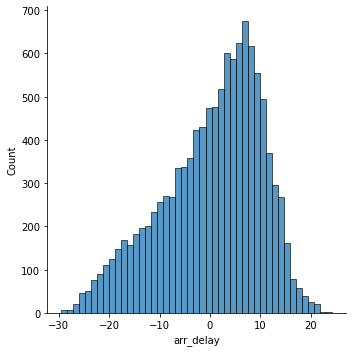

In [27]:
sns.displot(y_pred - y_test)

In [28]:
max(y_pred), min(y_pred)

(21.197106782106776, -2.5419931457431453)

In [29]:
save.jar(tree, 'random_forest_regressor')

In [30]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [31]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=99)

ridgereg = Ridge(alpha=0.001,normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)

In [32]:
print('Mean Squared Error: {0:0.4f}'.format(mean_squared_error(y_test, y_pred)))
print('RSME: {0:0.4f}'.format(mean_squared_error(y_test, y_pred, squared=False)))

Mean Squared Error: 83.6499
RSME: 9.1460


In [33]:
max(y_pred), min(y_pred)

(24.722123298347206, 2.182996088392135)

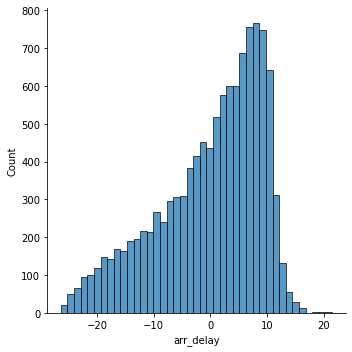

In [34]:
sns.displot(y_pred - y_test)

In [35]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=99)

lassoreg = Lasso(alpha=0.0001,normalize=False)
lassoreg.fit(X_train, y_train)
y_pred = lassoreg.predict(X_test)

In [36]:
print('Mean Squared Error: {0:0.4f}'.format(mean_squared_error(y_test, y_pred)))
print('RSME: {0:0.4f}'.format(mean_squared_error(y_test, y_pred, squared=False)))

Mean Squared Error: 83.6506
RSME: 9.1461


In [37]:
max(y_pred), min(y_pred)

(24.742797469748393, 2.174675084853113)

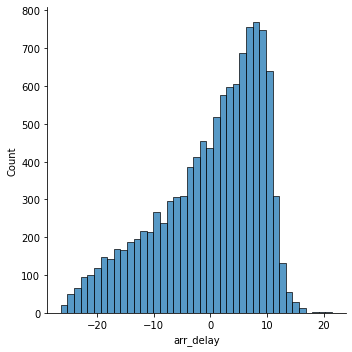

In [38]:
sns.displot(y_pred - y_test)